# Actin cortex drives membrane tension propagation in cells 
This Jupyter notebook show how to solve the one-dimensional model for the cortex-membrane composite system.
The plasma membrane is modelled as an elastic material, while the actin cortex is described as an active polymeric gel.
The membrane and cortex interact via adhesive linkers that are anchored into the actin cortex and generate drag forces proportional to the relative velocity between the cortex and membrane.

The system is an one-dimentional domain $\xi \in \Omega = [0,L]$, which is observed over a time $t \in (0, T)$. It is fully characterized by the displacement field $x(\xi, t)$ of the plasma membrane, and a velocity field $v(\xi,t)$ of the cortex, representing cortical flows.
The system of equation describing the system dynamics is

\begin{cases}
    &\displaystyle \frac{\partial x}{\partial t} + \frac{\eta}{\mu}\frac{\partial^2 v}{\partial \xi^2} + \frac{1}{\mu}\frac{\partial \sigma_{active}}{\partial \xi} - v = 0, 
    \quad\,\, & \text{in } \Omega \times (0,T] 
    \\
    &\displaystyle\frac{\partial x}{\partial t} = \frac{k}{\mu}\frac{\partial^2 x}{\partial \xi^2} + v, 
    \qquad & \text{in } \Omega \times (0,T]
    \\
    &x(\xi = 0 ) = 0, \text{ and } x(\xi = L) = \bar{x}   & \text{on } \partial \Omega \times (0,T]
    \\
    & v(\xi = 0)  = 0, \text{ and } v(\xi = L) = \bar{v} & \text{on } \partial \Omega \times (0,T]
\end{cases}
where $\eta [Pa.s.m]$ is the two-dimensional effective viscosity of the cortex, $k [N/m]$ is the elastic constant of the membrane, $\mu [Pa.s.m]$ is the local friction coefficient.


## Time discretization
In order to solve the above equations, for the displacement $x(\xi,t)$ and velocity $v(\xi,t)$, we first discuss the time discretization. We use the superscript $n$ to denote a quantity at discrete timesteps $t^n = n \Delta t$, where $n = 0, 1,2 ,\ldots$. For an arbitrary field $\phi(\xi, t)$, $\phi^n = \phi(\xi, t = t^n)$. A finite difference implicit discretization in time first consists of sampling the PDE system at some level, say $t^{n+1}$:


\begin{align}
    & \left(\frac{\partial x}{\partial t}\right)^{n+1} 
    + \frac{\eta}{\mu}\nabla^2 v^{n+1} 
    + \frac{1}{\mu}\nabla \sigma_{active}^{n+1} 
    - v^{n+1} = 0,
    \\
    &\left(\frac{\partial x}{\partial t}\right)^{n+1} = \frac{k}{\mu}\nabla^2 x^{n+1} 
    + v^{n+1}.
\end{align}
The time-derivative is then approximated by a difference quotient. For simplicity and stability reasons, we chose a simple backward Euler method:
\begin{equation}
    \left(\frac{\partial x}{\partial t}\right)^{n+1} \approx \frac{x^{n+1}-x^n}{\Delta t},
\end{equation}
where $\Delta t$ is the time discretization parameter. 

## Variational formulation

Let $\hat{x}$, and $\hat{v}$ be the test functions. We first approximate the time derivatives using \eqref{eq:backwards-euler}, then mutiply each equation by tests function, integrate over the spatial domain $\Omega$, and sum the equations. 

\begin{equation}
\begin{split}
    \int_{\Omega} (\Delta t^{-1}(x^{n+1}-x^n)\hat{v} 
    + \frac{\eta}{\mu} \nabla^2 v^{n+1}\hat{v} 
    + \frac{1}{\mu}\nabla \sigma_{active}^{n+1} \hat{v} 
    - v^{n+1}\hat{v} )   d\xi 
    \\
    + \int_{\Omega}(\Delta t^{-1}(x^{n+1}-x^n)\hat{x} 
    - \frac{k}{\mu} \nabla^2 x^{n+1}\hat{x} 
    - v^{n+1} \hat{x}) d\xi = 0
\end{split}
\end{equation}

Integration by parts allows us to write,


\begin{equation}
\begin{split}
    &\int_{\Omega} 
        (
        \Delta t^{-1} (x^{n+1} - x^n) \hat{v} 
        - \frac{\eta}{\mu} \nabla v^{n+1}\nabla \hat{v} 
        + \frac{1}{\mu} \nabla \sigma_{active}^{n+1} \hat{v} 
        - v^{n+1}\hat{v} 
        ) d\xi 
    \\
    + &\int_{\Omega}
        (
        \Delta t^{-1}(x^{n+1}-x^n)\hat{x} 
        + \frac{k}{\mu}\nabla x^{n+1}\nabla \hat{x} 
        - v^{n+1} \hat{x}
        ) d\xi = 0.
\end{split}
\end{equation}


In the article, we are mainly interested in understanding how tension is propagated along the cell. There are two main cases of interest. In the "exogenous perturbation", the plasma membrane is pulled by an optical trap. In the so-called "endogenous perturbation", we used an optogenetic tool to locally generate actin-driven cellular protrusions.


## Exogenous perturbation
We modelled the perturbation on the membrane by an optical trap as a Dirichlet boundary condition on the displacement field $x(\xi = L, t)$

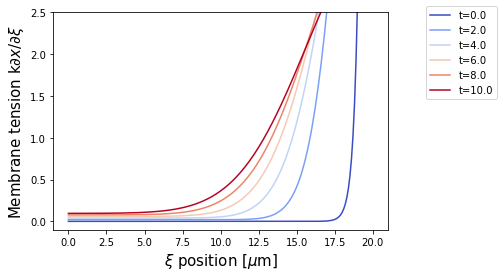

In [2]:
import numpy as np
from Solver import Solver
from fenics import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm


n_elements = 200
# Physical parameters
k = 100.                # [pN/um]
L = 20.                # [um] System size length
eta = 10000            # [pN s/ um] 2D viscosity of the cortex
mu = 100               # [pN s/um^3] friction coefficient

imposed_displacement = 0.01 * L    # [um]  imposed displacement 5% of the membrane length
imposed_velocity = 0.0
time_step = 0.1

tf = 10
average_force = []
time_current = 0
i = 0
total_steps = tf/time_step

problem = Solver(L,
        n_elements,
        k,
        eta,
        mu,
        imposed_displacement,
        imposed_velocity,
        time_step)


# Set the boundary conditions
def left_end(x, on_boundary):
        return near(x[0], 0) and on_boundary
def right_end(x, on_boundary):
        return near(x[0], problem.L) and on_boundary
bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
                DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end),
                DirichletBC(problem.Q.sub(0), problem.imposed_displacement, right_end)])


fig1 = plt.figure(1)


while time_current< tf:
        
        problem.solve(bc)
        membrane_force = project(k*problem.q_solution.sub(0).dx(0), problem.Q.sub(0).collapse())
        average_force= np.append(average_force, membrane_force(L/2))
        
        if i%20 == 0:
                plt.figure(1)
                plot(membrane_force, label=f"t={time_current:1.1f}",color=cm.coolwarm(i/(total_steps)))
        time_current += time_step
        i+=1


plt.figure(1)
# plt.title("Force developed on the membrane")
plt.xlabel(r"$\xi$ position [$\mu$m]",size=15)
# plt.ylabel(r"k$\partial x/\partial \xi$")
plt.ylabel("Membrane tension " + r"k$\partial x/\partial \xi$",size=15)
plt.ylim(-.1, 2.5)
plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.1, 1.05))

### Discussion
Note that the system is essentially a diffusion of the tension, which is buffered by the friction. The tension propagation in this case is higly dependent on the time scale of observation, since as $t \to \infty$ the tension would be everywhere homogeneous. 

## Endogenous perturbation
The endogenous force generation can be modelled in two different ways providing same qualitative features. First, as an active source of contraction via the term $\sigma$, or via a Dirichlet boundary condition on the velocity field $v(\xi = L,t) = \bar v$, which is used here for simplicity. The boundary condition is complemented with a full clamp at $\xi = 0$, and by unconstraining the membrane at $\xi = L$.

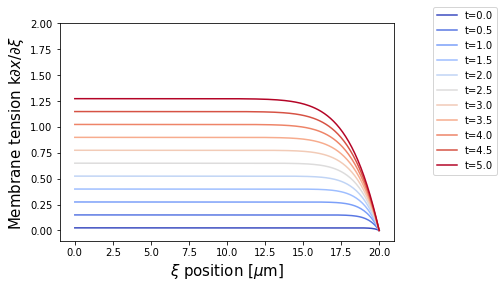

In [8]:
imposed_displacement = 0.00 * L    # [um]  imposed displacement 5% of the membrane length
imposed_velocity = 0.05
time_current = 0
i=0
tf = 5
total_steps = tf/time_step

problem = Solver(L,
        n_elements,
        k,
        eta,
        mu,
        imposed_displacement,
        imposed_velocity,
        time_step)

fig1 = plt.figure(1)

def left_end(x, on_boundary):
        return near(x[0], 0) and on_boundary

def right_end(x, on_boundary):
        return near(x[0], problem.L) and on_boundary
bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
                DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end)])

while time_current< tf:
        problem.solve(bc)
        membrane_force = project(k*problem.q_solution.sub(0).dx(0), problem.Q.sub(0).collapse())
        average_force= np.append(average_force, membrane_force(L/2))
        if i%5 == 0:
                plt.figure(1)
                plot(membrane_force, label=f"t={time_current:1.1f}",color=cm.coolwarm(i/(total_steps)))
        time_current += time_step
        i+=1


# plt.title("Force developed on the membrane")
plt.xlabel(r"$\xi$ position [$\mu$m]",size=15)
# plt.ylabel(r"k$\partial x/\partial \xi$")
plt.ylabel("Membrane tension " + r"k$\partial x/\partial \xi$",size=15)
plt.ylim(-.1, 2.)
plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.1, 1.10))

## Dynamics of tension propagation

Consider here the case of endogenous perturbations.

Text(0, 0.5, 'Trap force')

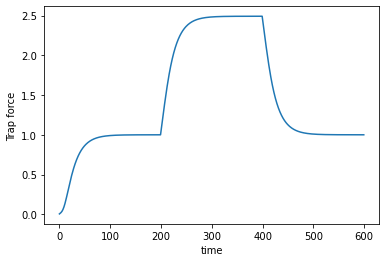

In [5]:
n_elements = 200
# Physical parameters
k = 100.                # [pN/um]
L = 20.                # [um] System size length
eta = 10000            # [pN s/ um] 2D viscosity of the cortex
mu = 100               # [pN s/um^3] friction coefficient

imposed_displacement = 0.01 * L    # [um]  imposed displacement 5% of the membrane length
imposed_velocity = 0.1
time_current = 0
i=0
problem = Solver(L,
        n_elements,
        k,
        eta,
        mu,
        imposed_displacement,
        imposed_velocity,
        time_step)


def left_end(x, on_boundary):
        return near(x[0], 0) and on_boundary

def right_end(x, on_boundary):
        return near(x[0], problem.L) and on_boundary

bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
                DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end),
                DirichletBC(problem.Q.sub(0), problem.imposed_displacement, right_end)])

tf = 600
time_step = 1
average_force = []
time = []
while time_current< tf:
        if time_current < 200:
            problem.imposed_velocity = .0
        elif time_current < 400: 
            problem.imposed_velocity = .02
        else:
            problem.imposed_velocity = .0
            
        bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
                DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end),
                DirichletBC(problem.Q.sub(0), problem.imposed_displacement, right_end)])
        problem.solve(bc)
        membrane_force = project(k*problem.q_solution.sub(0).dx(0), problem.Q.sub(0).collapse())
        average_force= np.append(average_force, membrane_force(L/2))
        time = np.append(time, time_current)
        time_current += time_step
        i+=1

plt.figure()
plt.plot(time, average_force)
# plt.plot(time, 10*(1 + average_force))
plt.xlabel("time")
plt.ylabel("Trap force")

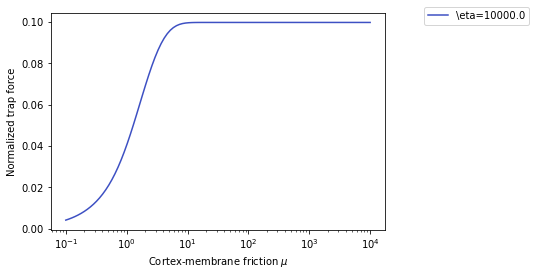

In [26]:
def trap_force(problem, bc, time_step,tf):
    time_current = 0
    average_force = []
    while time_current< tf:
            problem.solve(bc)
            membrane_force = project(problem.k*problem.x_s.dx(0), problem.Q.sub(0).collapse())
            average_force= np.append(average_force, membrane_force(problem.L/2))
            time_current += time_step
    return average_force


force_at_time_t = []
# force_at_time_t = np.append(force_at_time_t, 0) 
fig1 = plt.figure(1)
Eta = np.logspace(2,5, num = 10)
Mu = np.logspace(-1, 4.0, num=100)
i = 0
tf = 10
imposed_displacement = 0.0*L
imposed_velocity = 0.02
k = 25                 # [pN/um]
L = 50.                # [um] System size length
eta = 10000
time_step = 0.1

average_force = []
time = []
force_at_time_t = []
for mu in Mu:
    average_force = []
    problem = Solver(L,
                    n_elements,
                    k,
                    eta,
                    mu,
                    imposed_displacement,
                    imposed_velocity,
                    time_step)
    bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
            DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end),
            DirichletBC(problem.Q.sub(0), problem.imposed_displacement, right_end)])
    average_force = trap_force(problem, bc,time_step, tf)
    force_at_time_t = np.append(force_at_time_t, average_force[-1])

i+=1

plt.figure(1)
plt.semilogx(Mu,force_at_time_t, label=f"\eta={eta:1.1f}",color=cm.coolwarm(i/len(Mu)))

plt.xlabel(r'Cortex-membrane friction $\mu$')
plt.ylabel('Normalized trap force')
plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.1, 1.05))
from tikzplotlib import save as tikz_save



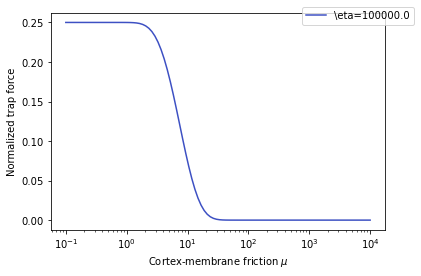

In [17]:
def trap_force(problem, bc, time_step,tf):
    time_current = 0
    average_force = []
    while time_current< tf:
            problem.solve(bc)
            membrane_force = project(problem.k*problem.x_s.dx(0), problem.Q.sub(0).collapse())
            average_force= np.append(average_force, membrane_force(problem.L/2))
            time_current += time_step
    return average_force


force_at_time_t = []
# force_at_time_t = np.append(force_at_time_t, 0) 
fig1 = plt.figure(1)
Eta = np.logspace(2,5, num = 10)
Mu = np.logspace(-1, 4.0, num=100)
i = 0
tf = 10
imposed_displacement = 0.01*L
imposed_velocity = 0.0
k = 10                 # [pN/um]
L = 20.                # [um] System size length
eta = 100000
time_step = 0.1

average_force = []
time = []
force_at_time_t = []
for mu in Mu:
    average_force = []
    problem = Solver(L,
                    n_elements,
                    k,
                    eta,
                    mu,
                    imposed_displacement,
                    imposed_velocity,
                    time_step)
    bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
            DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end),
            DirichletBC(problem.Q.sub(0), problem.imposed_displacement, right_end)])
    average_force = trap_force(problem, bc,time_step, tf)
    force_at_time_t = np.append(force_at_time_t, average_force[-1])

i+=1

plt.figure(1)
plt.semilogx(Mu,force_at_time_t, label=f"\eta={eta:1.1f}",color=cm.coolwarm(i/len(Mu)))

plt.xlabel(r'Cortex-membrane friction $\mu$')
plt.ylabel('Normalized trap force')
plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.1, 1.05))


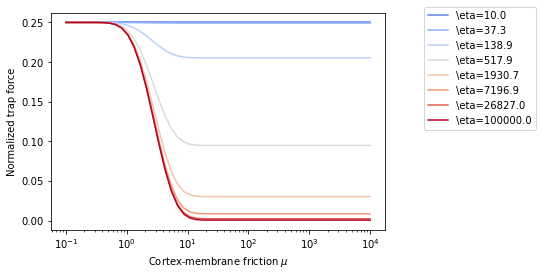

In [29]:
Eta = np.logspace(1,5, num = 8)
Mu = np.logspace(-1, 4.0, num=50)
imposed_displacement = 0.01*L
imposed_velocity = 0
time_step = 0.5
i=0
for eta in Eta:
    average_force = []
    time = []
    force_at_time_t = []
    for mu in Mu:
        average_force = []
        problem = Solver(L,
                        n_elements,
                        k,
                        eta,
                        mu,
                        imposed_displacement,
                        imposed_velocity,
                        time_step)
        bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
                DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end),
                DirichletBC(problem.Q.sub(0), problem.imposed_displacement, right_end)])
        # print(problem.imposed_displacement)
        average_force = trap_force(problem, bc,time_step, tf)
        # plt.plot(average_force)
        force_at_time_t = np.append(force_at_time_t, average_force[-1])
    
    i+=1

    plt.figure(1)
    plt.semilogx(Mu,force_at_time_t, label=f"\eta={eta:1.1f}",color=cm.coolwarm(i/len(Eta)))

plt.xlabel(r'Cortex-membrane friction $\mu$')
plt.ylabel('Normalized trap force')
plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.1, 1.05))

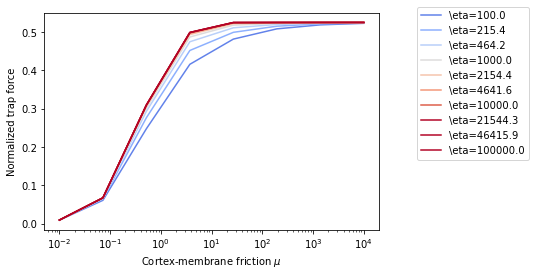

In [25]:
Eta = np.logspace(2,5, num = 10)
Mu = np.logspace(-2, 4.0, num=8)
imposed_displacement = 0.0*L
imposed_velocity = 0.05
time_step = 0.5
i=0
for eta in Eta:
    average_force = []
    time = []
    force_at_time_t = []
    for mu in Mu:
        average_force = []
        problem = Solver(L,
                        n_elements,
                        k,
                        eta,
                        mu,
                        imposed_displacement,
                        imposed_velocity,
                        time_step)
        bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
                DirichletBC(problem.Q.sub(1), problem.imposed_velocity, right_end)])
        # print(problem.imposed_displacement)
        average_force = trap_force(problem, bc,time_step, tf)
        # plt.plot(average_force)
        force_at_time_t = np.append(force_at_time_t, average_force[-1])
    
    i+=1

    plt.figure(1)
    plt.semilogx(Mu,force_at_time_t, label=f"\eta={eta:1.1f}",color=cm.coolwarm(i/len(Mu)))

plt.xlabel(r'Cortex-membrane friction $\mu$')
plt.ylabel('Normalized trap force')
plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.1, 1.05))

As a validation for our finite element approach of the coupled system, we compare the results of our code against a simplified setting where analytical solutions are possible. The simplest case assumes constant contractility, where we can set $v= 0$ and the solve the membrane equilibrium equation, 
\begin{equation}
\begin{split}
    & \frac{\partial x}{\partial t} = \frac{k}{\mu}\frac{\partial^2 x}{\partial \xi^2}, \qquad (\xi, t) \in [0,L]\times (0,\infty)
    \\
    & x(\xi, t = 0) = g(\xi)
    \\
    &  x(\xi = 0, t ) = 0.
\end{split}
\end{equation}
which is similat to a heat equation with boundary conditions. Such equation has a closed analytical solution

\begin{equation}
    x(\xi, t ) = \int_{0}^\infty \frac{1}{\sqrt{4 \pi \lambda t }} \left[ e^{-\frac{(\xi - y)^2}{4 \lambda t}} - e^{ -\frac{(\xi + y)^2}{4 \lambda t }} \right] g(\xi) dy,
\end{equation}
where $k/\mu = \lambda$. To simulate a pull of size $\ell$ from the optical trap we set $g(\xi) = \ell \delta(\xi - L)$, which simplifies the solution to 

\begin{equation}
    x(\xi, t ) = \frac{1}{\sqrt{4 \pi \lambda t }} \left[ e^{-\frac{(\xi - L)^2}{4 \lambda t}} - e^{ -\frac{(\xi + L)^2}{4 \lambda t }} \right] \ell .
\end{equation}


UFLValueError: Invalid type conversion: [-2.50000000e+02 -2.39900042e+02 -2.30008330e+02 -2.20324865e+02
 -2.10849646e+02 -2.01582674e+02 -1.92523948e+02 -1.83673469e+02
 -1.75031237e+02 -1.66597251e+02 -1.58371512e+02 -1.50354019e+02
 -1.42544773e+02 -1.34943773e+02 -1.27551020e+02 -1.20366514e+02
 -1.13390254e+02 -1.06622241e+02 -1.00062474e+02 -9.37109538e+01
 -8.75676801e+01 -8.16326531e+01 -7.59058726e+01 -7.03873386e+01
 -6.50770512e+01 -5.99750104e+01 -5.50812162e+01 -5.03956685e+01
 -4.59183673e+01 -4.16493128e+01 -3.75885048e+01 -3.37359434e+01
 -3.00916285e+01 -2.66555602e+01 -2.34277384e+01 -2.04081633e+01
 -1.75968347e+01 -1.49937526e+01 -1.25989171e+01 -1.04123282e+01
 -8.43398584e+00 -6.66389005e+00 -5.10204082e+00 -3.74843815e+00
 -2.60308205e+00 -1.66597251e+00 -9.37109538e-01 -4.16493128e-01
 -1.04123282e-01 -0.00000000e+00] can not be converted to any UFL type.

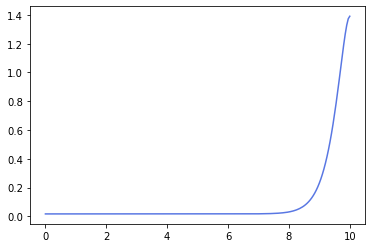

<Figure size 432x288 with 0 Axes>

In [23]:
import numpy as np
from Solver import Solver
from fenics import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def heat_equation(k,t,x, L):
        return (1/np.sqrt(4*pi*k*t))*(np.exp(-(x-L)**2/(4*k*t)) - np.exp(-(x+L)**2/(4*k*t)) )


n_elements = 200
# Physical parameters
k = 1.               # [pN/um]
L = 10.                # [um] System size length
eta = 1            # [pN s/ um] 2D viscosity of the cortex
mu = 1               # [pN s/um^3] friction coefficient

imposed_displacement = 1     # [um]  imposed displacement 5% of the membrane length
imposed_velocity = 0.0
time_step = 0.1

tf = 1
average_force = []
time_current = 0
i = 0
total_steps = tf/time_step

problem = Solver(L,
        n_elements,
        k,
        eta,
        mu,
        imposed_displacement,
        imposed_velocity,
        time_step)


# Set the boundary conditions
def left_end(x, on_boundary):
        return near(x[0], 0) and on_boundary
def right_end(x, on_boundary):
        return near(x[0], problem.L) and on_boundary
def boundary(x, on_boundary):
        return on_boundary
bc = ([DirichletBC(problem.Q, Constant((0.,0.)), left_end),
                DirichletBC(problem.Q.sub(1), problem.imposed_velocity, boundary),
                DirichletBC(problem.Q.sub(0), problem.imposed_displacement, right_end)])


fig1 = plt.figure(1)
fig1 = plt.figure(2)

while time_current< tf:
        
        problem.solve(bc)
        membrane_force = project(k*problem.q_solution.sub(0).dx(0), problem.Q.sub(0).collapse())
        average_force= np.append(average_force, membrane_force(L/2))
        
        if i%2 == 1:
                plt.figure(1)
                plot(membrane_force, label=f"t={time_current:1.1f}",color=cm.coolwarm(i/(total_steps)))

                


        time_current += time_step
        i+=1


plt.figure(1)
# plt.title("Force developed on the membrane")
plt.xlabel(r"$\xi$ position [$\mu$m]",size=15)
# plt.ylabel(r"k$\partial x/\partial \xi$")
plt.ylabel("Membrane tension " + r"k$\partial x/\partial \xi$",size=15)
# plt.ylim(-.1, 2.5)
plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [25]:
heat_equation(k/mu,time_current,np.linspace(0,L),L)

UFLValueError: Invalid type conversion: [-2.50000000e+02 -2.39900042e+02 -2.30008330e+02 -2.20324865e+02
 -2.10849646e+02 -2.01582674e+02 -1.92523948e+02 -1.83673469e+02
 -1.75031237e+02 -1.66597251e+02 -1.58371512e+02 -1.50354019e+02
 -1.42544773e+02 -1.34943773e+02 -1.27551020e+02 -1.20366514e+02
 -1.13390254e+02 -1.06622241e+02 -1.00062474e+02 -9.37109538e+01
 -8.75676801e+01 -8.16326531e+01 -7.59058726e+01 -7.03873386e+01
 -6.50770512e+01 -5.99750104e+01 -5.50812162e+01 -5.03956685e+01
 -4.59183673e+01 -4.16493128e+01 -3.75885048e+01 -3.37359434e+01
 -3.00916285e+01 -2.66555602e+01 -2.34277384e+01 -2.04081633e+01
 -1.75968347e+01 -1.49937526e+01 -1.25989171e+01 -1.04123282e+01
 -8.43398584e+00 -6.66389005e+00 -5.10204082e+00 -3.74843815e+00
 -2.60308205e+00 -1.66597251e+00 -9.37109538e-01 -4.16493128e-01
 -1.04123282e-01 -0.00000000e+00] can not be converted to any UFL type.